# Dev: Save frames in parallel using dask

In [1]:
import xarray as xr
import numpy as np
from xmovie import Movie
import matplotlib.pyplot as plt

In [2]:
def plotfunc(da, fig, timestep):
    ax = fig.subplots()
    da.isel(time=timestep).plot(ax=ax)
    
    
def frame_save_ser():
    
def frame_save_par():

In [3]:
da = xr.DataArray(np.random.rand(4,5,50), coords = [('x', range(4)), ('y', range(5)), ('time', range(50))])
da

<xarray.DataArray (x: 4, y: 5, time: 50)>
array([[[0.976021, 0.207992, ..., 0.101315, 0.617789],
        [0.801817, 0.31277 , ..., 0.50996 , 0.692224],
        ...,
        [0.754264, 0.805735, ..., 0.896399, 0.475445],
        [0.886645, 0.697206, ..., 0.924236, 0.863823]],

       [[0.801019, 0.279433, ..., 0.485698, 0.415899],
        [0.222982, 0.199033, ..., 0.003426, 0.862211],
        ...,
        [0.044153, 0.924587, ..., 0.224351, 0.567444],
        [0.475995, 0.313636, ..., 0.478189, 0.096597]],

       [[0.878134, 0.599801, ..., 0.077371, 0.444477],
        [0.271943, 0.202492, ..., 0.321458, 0.52784 ],
        ...,
        [0.880629, 0.777828, ..., 0.574982, 0.995005],
        [0.876125, 0.799121, ..., 0.166272, 0.098742]],

       [[0.12217 , 0.46207 , ..., 0.417638, 0.798813],
        [0.266423, 0.19229 , ..., 0.459707, 0.552302],
        ...,
        [0.575955, 0.341485, ..., 0.346549, 0.714817],
        [0.203364, 0.95424 , ..., 0.016921, 0.098896]]])
Coordinates:
  * x

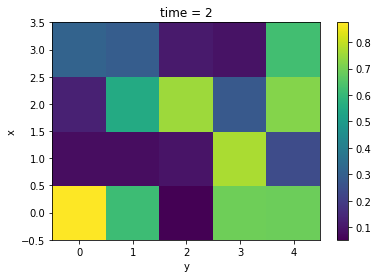

In [4]:
# Test plotfunc directly
fig = plt.figure()
plotfunc(da, fig, 2)

In [5]:
import os
odir = '/Users/juliusbusecke/Desktop/movie_test'
odir_par = os.path.join(odir, 'par')
odir_ser = os.path.join(odir, 'ser')

partition_size = 8 # may be to many for my laptop

## First test (with numpy array input)

In [9]:
# Clean up all temp dirs
for di in [odir, odir_ser, odir_par]:
    !rm {di}/*.png

rm: /Users/juliusbusecke/Desktop/movie_test/*.png: No such file or directory
rm: /Users/juliusbusecke/Desktop/movie_test/ser/*.png: No such file or directory


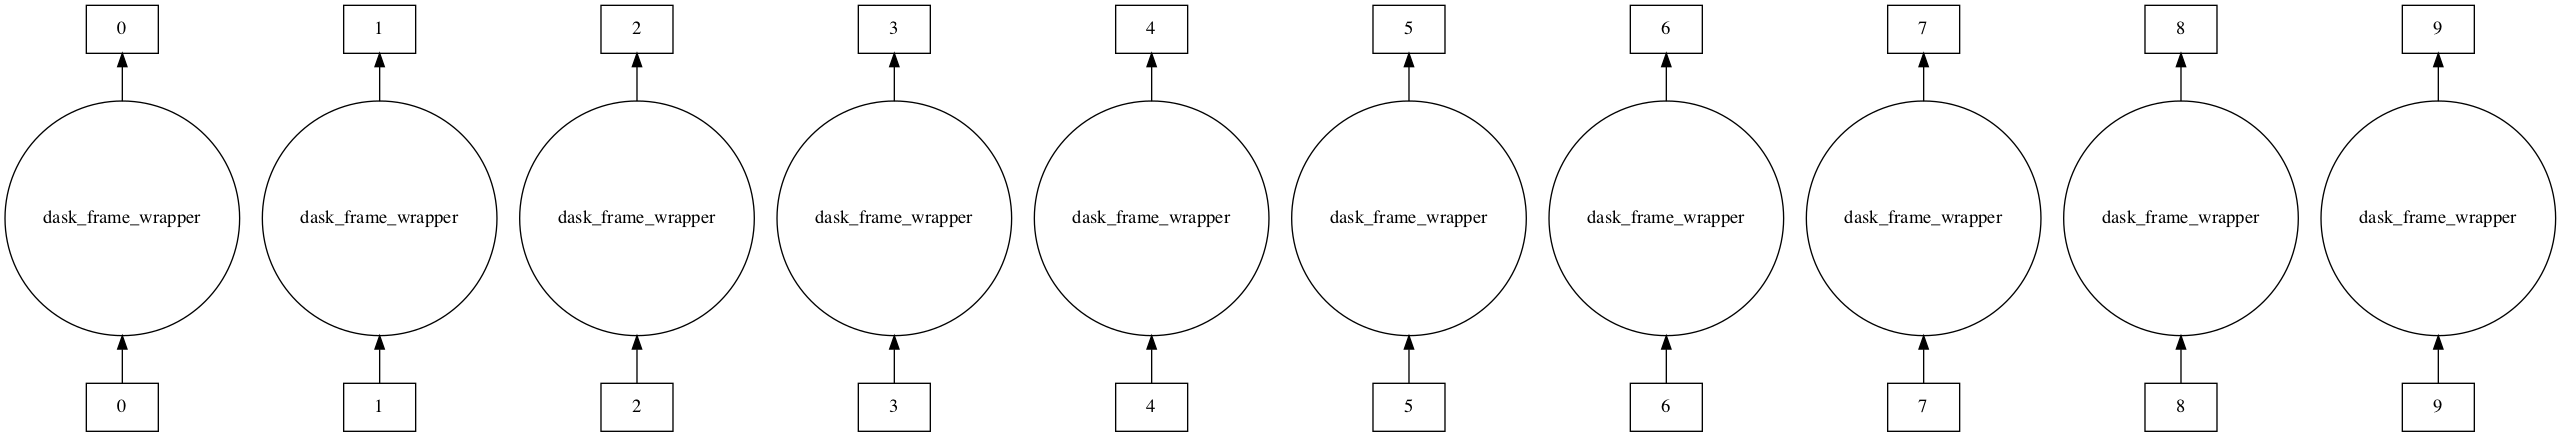

In [10]:
# first try it with the raw (numpy array)
data = da
mov = Movie(data, plotfunc)
m_bag = mov.save_frames_parallel(odir, compute=False)
m_bag.visualize()

Looks nice and parallel to me. Lets see if we can a good speedup...

In [11]:
%time mov.save_frames_parallel(odir_par, compute=True)
%time mov.save_frames_serial(odir_par)

CPU times: user 43.8 ms, sys: 21.7 ms, total: 65.4 ms
Wall time: 5.29 s
CPU times: user 11.5 s, sys: 377 ms, total: 11.9 s
Wall time: 12.1 s


## Dask array input for plot

In [12]:
# Clean up all temp dirs
for di in [odir, odir_ser, odir_par]:
    !rm {di}/*.png

rm: /Users/juliusbusecke/Desktop/movie_test/*.png: No such file or directory
rm: /Users/juliusbusecke/Desktop/movie_test/ser/*.png: No such file or directory


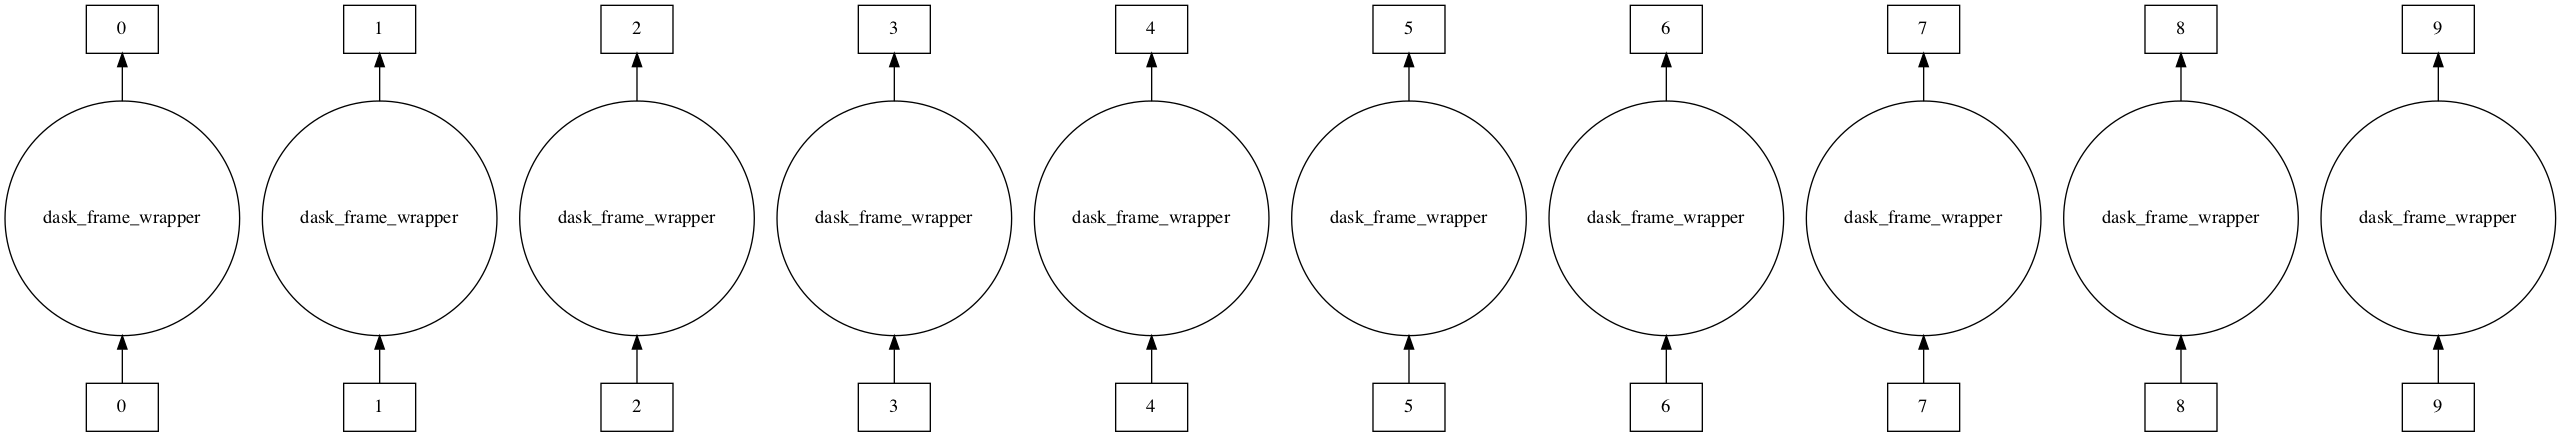

In [13]:
# now with a dask array
data = da.chunk({'time':1})
mov = Movie(data, plotfunc)
m_bag = mov.save_frames_parallel(odir, compute=False)
m_bag.visualize()

In [ ]:
%time mov.save_frames_parallel(odir_par, compute=True)
%time mov.save_frames_serial(odir_par)

KeyboardInterrupt: 

*WTF* is happening here? 

If I execute the dask test first it runs normally, but if I execute it after the numpy test it just gets stuck? Is some variable not cleared?

In [ ]:
# performance check
for data, data_name in zip([da, da.chunk({'time':1})], ['numpy', 'dask']):
    for psize in range(2,8,2):
        #Clean the odirs beforehand
        for di in [odir_ser, odir_par]:
            !rm {di}/*.png

        mov = Movie(data, plotfunc)
        print('################################################')
        print('Array: %s Partitionsize: %i' %(data_name, psize))
        print('################################################')
        print('# Serial Save #')
        %time mov.save_frames_serial(odir_ser)

        print('# Parallel Save #')
        %time mov.save_frames_parallel(odir_par, partition_size=psize, compute=True)

So this is strange: When I loop over different input and partition size cases saving frames in parallel from a dask array always gets stuck. 
I have really no clue why? The same thing worked above when not in a loop...